# Отток клиентов из телекоммуникационной компании.

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, компании нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Задача:** обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг:**
Оператор предоставляет два основных типа услуг:
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).
Также абонентам доступен ряд услуг:
Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
Выделенная линия технической поддержки (Tech Support);
Облачное хранилище файлов для резервного копирования данных (Online Backup);
Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).
За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных:**
Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- *contract* — информация о договорах;
- *personal* — персональные данные клиентов;
- *internet* — информация об интернет-услугах;
- *phone* — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.

## Подключение к базе данных. Загрузка таблиц SQL.

### Установка программных пакетов и импорт необходимых библиотек.

In [1]:
!pip install ydata-profiling --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is no

In [2]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00


In [3]:
!pip install --upgrade scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.1 MB/s eta 0:00:00


In [4]:
!pip install phik --quiet

In [5]:
!pip install tqdm --quiet

In [8]:
import pandas as pd
import numpy as np

import itertools
import math

import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy

from sqlalchemy import create_engine, text

from ydata_profiling import ProfileReport

from tqdm.notebook import tqdm_notebook
from sklearn.utils import parallel_backend

from numpy.random import RandomState
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score

from catboost import CatBoostClassifier

import psycopg2

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

import phik
from phik import resources, report

from tqdm import tqdm

SEED = 171023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings('ignore')

### Создание конфигурации для подключения к базе данных `data-science-final`.

In [9]:
db_config = {
'user': '_______________',
'pwd': '_____________',
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,
'db': '__________________'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

### Создание подключения.

In [10]:
con = psycopg2.connect(
    host=db_config['host'],
    port=db_config['port'],
    database=db_config['db'],
    user=db_config['user'],
    password=db_config['pwd']
)

### Загрузка таблицы contract и сохранение ее в датафрейме.

In [11]:
query = '''
SELECT *
FROM telecom.contract;
'''

contract = pd.read_sql_query(query, con=con)

### Загрузка таблицы personal и сохранение ее в датафрейме.

In [12]:
query = '''
SELECT *
FROM telecom.personal;
'''

personal = pd.read_sql_query(query, con=con)

### Загрузка таблицы internet и сохранение ее в датафрейме.

In [13]:
query = '''
SELECT *
FROM telecom.internet;
'''

internet = pd.read_sql_query(query, con=con)

### Загрузка таблицы phone и сохранение ее в датафрейме.

In [14]:
query = '''
SELECT *
FROM telecom.phone;
'''

phone = pd.read_sql_query(query, con=con)

## Исследовательский анализ и предобработка данных.

### Исследование и предобработка датафрейма contract.

#### Первичное исследование данных.

In [15]:
# выводим первые 5 строк датафрейма
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


**Предварительные выводы:**
- В столбцах BeginDate и EndDate некорректно указан тип данных.
- В столбцах EndDate и TotalCharges есть пропуски.
- Данные в столбце PaperlessBilling	следует преобразовать для облегчения последующего машинного обучения.

In [17]:
# преобразуем тип данных в столбцах BeginDate и EndDate в datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

#### Создаем новый столбец с длительностью договора.

In [18]:
# задание даты для пропусков в столбце EndDate (т.е. для длящихся договоров) -
# дата, на которую была обновлена информация о договорах в базе данных.
default_date = pd.Timestamp('2020-02-01')

# расчет длительности договора для каждого клиента
contract['ContractDuration'] = (contract['EndDate'].fillna(default_date) - contract['BeginDate']).dt.days

contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,479
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,279


#### Удаляем столбец BeginDate.

In [19]:
contract.drop('BeginDate', axis=1, inplace=True)

#### Создаем и исследуем новый столбец с ежедневными расходами абонента.

In [20]:
# Создание нового столбца
contract['DailyCharges'] = (contract['TotalCharges'] / contract['ContractDuration']).astype('float64').round(1)

contract.sample(5)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,DailyCharges
3596,1104-FEJAM,NaT,Month-to-month,No,Electronic check,64.40,1802.15,144,12.5
4981,8706-HRADD,NaT,Month-to-month,Yes,Mailed check,43.55,1011.50,344,2.9
909,4112-LUEIZ,2020-01-01,Month-to-month,Yes,Electronic check,89.50,863.10,210,4.1
737,2691-NZETQ,2020-01-01,Month-to-month,Yes,Electronic check,85.35,758.60,186,4.1
4547,8707-RMEZH,NaT,One year,No,Credit card (automatic),87.30,6055.55,336,18.0


In [21]:
# Исследуем данные по столбцу
contract['DailyCharges'].describe()

count    7032.000000
mean        8.768515
std        19.728024
min         0.000000
25%         1.400000
50%         4.900000
75%        13.100000
max      1421.300000
Name: DailyCharges, dtype: float64

In [22]:
# удаляем очевидные выбросы
contract = contract[contract['DailyCharges'] <= 200]

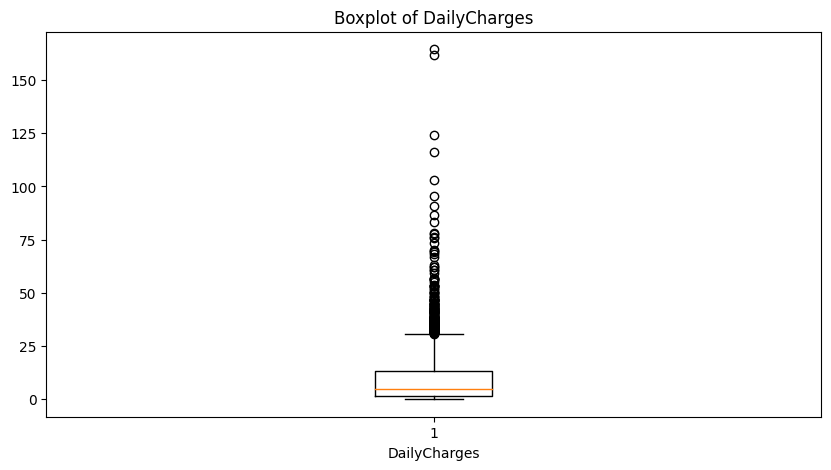

In [23]:
# снова строим диаграмму boxplot для выявления выбросов
plt.figure(figsize=(10, 5))
plt.boxplot(contract['DailyCharges'])
plt.title('Boxplot of DailyCharges')
plt.xlabel('DailyCharges')
plt.show()

In [24]:
# вычисляем верхнюю границу значений, после которой начинаются выбросы
Q1 = contract['DailyCharges'].quantile(0.25)
Q3 = contract['DailyCharges'].quantile(0.75)
IQR = Q3 - Q1

upper_boundary = Q3 + 1.5 * IQR
print(f"Верхняя граница для определения выбросов: {upper_boundary}")

Верхняя граница для определения выбросов: 30.65


In [25]:
# удаляем оставшиеся выбросы
contract = contract[contract['DailyCharges'] <= 31]

#### Преобразуем столбец EndDate в столбец с целевой переменной.

In [26]:
contract['Churned'] = contract['EndDate'].notna().astype(int)

# удаляем исходных столбец EndDate
contract.drop('EndDate', axis=1, inplace=True)

In [27]:
contract.head(5)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,DailyCharges,Churned
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,479,0.2,1
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,279,0.5,1
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,310,2.6,1
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,188,16.2,1
12,0280-XJGEX,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,322,15.6,1


#### Удаляем строки с оставшимися пропусками.

In [28]:
contract.dropna(inplace=True)

#### Преобразовываем формат данных для опитимизации машинного обучения.

In [29]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].round().astype('int64')
contract['TotalCharges'] = contract['TotalCharges'].round().astype('int64')

In [30]:
contract = contract.convert_dtypes()

#### Формируем отчет и делаем выводы.

In [31]:
# # cоздаем отчет
# profile = ProfileReport(contract)

**Выводы:**
- В датасете наблюдается дисбаланс классов: текущих клиентов в два с лишним раза больше, чем ушедших.
- Было создано два новых признака, на их основе были выявлены и удалены аномальные строки их таблицы.
- Наибольшее влияние на целевую переменную оказывают признаки Type, PaymentMethod и MonthlyCharges, наименьшее - длительность договора.

### Исследование и предобработка датафрейма personal.

#### Первичное исследование данных.

In [32]:
# выводим первые 5 строк датафрейма
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [33]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Предварительные выводы:**
- Пропуски отсутствуют.
- Данные в столбцах Partner и Dependents	следует преобразовать для облегчения последующего машинного обучения.

#### Преобразовываем данные в столбце SeniorCitizen.

In [34]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({1 : 'Yes', 0 : 'No'})

In [35]:
# # cоздаем отчет
# profile = ProfileReport(personal)
# profile.to_notebook_iframe()

### Исследование и предобработка датафрейма internet.

#### Первичное исследование данных.

In [36]:
# выводим первые 5 строк датафрейма
internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [37]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


**Выводы:**
- Пропуски отсутствуют.
- Необходимо скорректировать заголовки столбцов
- Данные в столбцах следует преобразовать для облегчения последующего машинного обучения.
- Данных в этой таблице значительно меньше, чем в таблице с целевой переменной (не все клиенты пользуются интернет-услугами).

#### Корректируем заголовки столбцов.

In [38]:
internet.columns = internet.iloc[0]
internet = internet.drop(internet.index[0])

### Исследование и предобработка датафрейма phone.

#### Первичное исследование данных.

In [39]:
# выводим первые 5 строк датафрейма
phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


In [40]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы:**
- Пропуски отсутствуют.
- Необходимо скорректировать заголовки столбцов
- Данные в столбце MultipleLines следует преобразовать для облегчения последующего машинного обучения.
- Данных в этой таблице значительно меньше, чем в таблице с целевой переменной (не все клиенты используют стационарную телефонную связь).

#### Корректируем заголовки столбцов.

In [41]:
phone.columns = phone.iloc[0]
phone = phone.drop(phone.index[0])

In [42]:
phone.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


### Выводы по итогам исследовательского анализа данных.

- Количество таблиц и содержащиеся в них данные соответствуют описанию задачи.
- Было выявлено и устранено незначительное количество пропусков.
- В таблице contract на основе новых признаков были выявлены и удалены аномалии.
- Как и ожидалось, не все клиенты пользуются интернет-услугами и не все клиенты пользуются стационарной телефонной связью.
- Некоторые данные с бинарными строковыми значениями были предобработаны в целях облегчения последующего машинного обучения.
- Был выявлен дисбаланс классов в целевой переменной.
- Таблицы готовы к объединению.

### Объединение таблиц.

In [43]:
# объединяем таблицы contract и personal
data = pd.merge(contract, personal, on='customerID', how='left')

In [44]:
# присоединяем к получившемуся датасету таблицу internet
data = pd.merge(data, internet, on='customerID', how='left')

In [45]:
# присоединяем к получившемуся датасету таблицу phone
data = pd.merge(data, phone, on='customerID', how='left')

In [46]:
# проверяем получившийся результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6834 non-null   object 
 1   Type              6834 non-null   string 
 2   PaperlessBilling  6834 non-null   string 
 3   PaymentMethod     6834 non-null   string 
 4   MonthlyCharges    6834 non-null   Int64  
 5   TotalCharges      6834 non-null   Int64  
 6   ContractDuration  6834 non-null   Int64  
 7   DailyCharges      6834 non-null   Float64
 8   Churned           6834 non-null   Int64  
 9   gender            6834 non-null   object 
 10  SeniorCitizen     6834 non-null   object 
 11  Partner           6834 non-null   object 
 12  Dependents        6834 non-null   object 
 13  InternetService   5315 non-null   object 
 14  OnlineSecurity    5315 non-null   object 
 15  OnlineBackup      5315 non-null   object 
 16  DeviceProtection  5315 non-null   object 


### Предобработка данных в объединенном датафрейме.

#### Создаем столбцы InternetUser и PhoneUser.

In [47]:
# Создаем столбец InternetUser
data['InternetUser'] = np.where(data['InternetService'].isna(), 'No', 'Yes')

# Создаем столбец PhoneUser
data['PhoneUser'] = np.where(data['MultipleLines'].isna(), 'No', 'Yes')

#### Заполняем пропуски.

In [48]:
data.fillna('No', inplace=True)

#### Удаляем столбец customerID.

In [49]:
data.drop('customerID', axis=1, inplace=True)

In [50]:
# проверяем полученный результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6834 non-null   string 
 1   PaperlessBilling  6834 non-null   string 
 2   PaymentMethod     6834 non-null   string 
 3   MonthlyCharges    6834 non-null   Int64  
 4   TotalCharges      6834 non-null   Int64  
 5   ContractDuration  6834 non-null   Int64  
 6   DailyCharges      6834 non-null   Float64
 7   Churned           6834 non-null   Int64  
 8   gender            6834 non-null   object 
 9   SeniorCitizen     6834 non-null   object 
 10  Partner           6834 non-null   object 
 11  Dependents        6834 non-null   object 
 12  InternetService   6834 non-null   object 
 13  OnlineSecurity    6834 non-null   object 
 14  OnlineBackup      6834 non-null   object 
 15  DeviceProtection  6834 non-null   object 
 16  TechSupport       6834 non-null   object 


#### Преобразовываем типы данных.

In [51]:
# Преобразование 'object' в 'string'
columns_to_convert = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'InternetUser',
    'PhoneUser'
]

for column in columns_to_convert:
    data[column] = data[column].astype('string')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6834 non-null   string 
 1   PaperlessBilling  6834 non-null   string 
 2   PaymentMethod     6834 non-null   string 
 3   MonthlyCharges    6834 non-null   Int64  
 4   TotalCharges      6834 non-null   Int64  
 5   ContractDuration  6834 non-null   Int64  
 6   DailyCharges      6834 non-null   Float64
 7   Churned           6834 non-null   Int64  
 8   gender            6834 non-null   string 
 9   SeniorCitizen     6834 non-null   string 
 10  Partner           6834 non-null   string 
 11  Dependents        6834 non-null   string 
 12  InternetService   6834 non-null   string 
 13  OnlineSecurity    6834 non-null   string 
 14  OnlineBackup      6834 non-null   string 
 15  DeviceProtection  6834 non-null   string 
 16  TechSupport       6834 non-null   string 


### Исследовательский анализ данных в объединенном датафрейме.

#### Визуализируем соотношение ушедших и оставшихся клиентов для каждого признака.

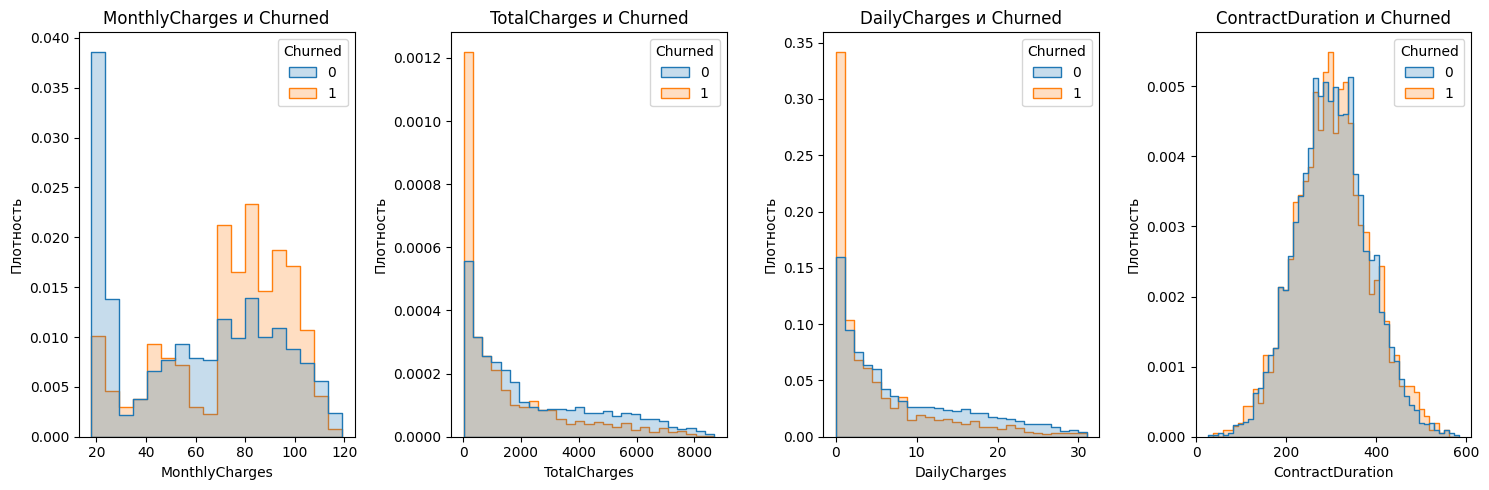

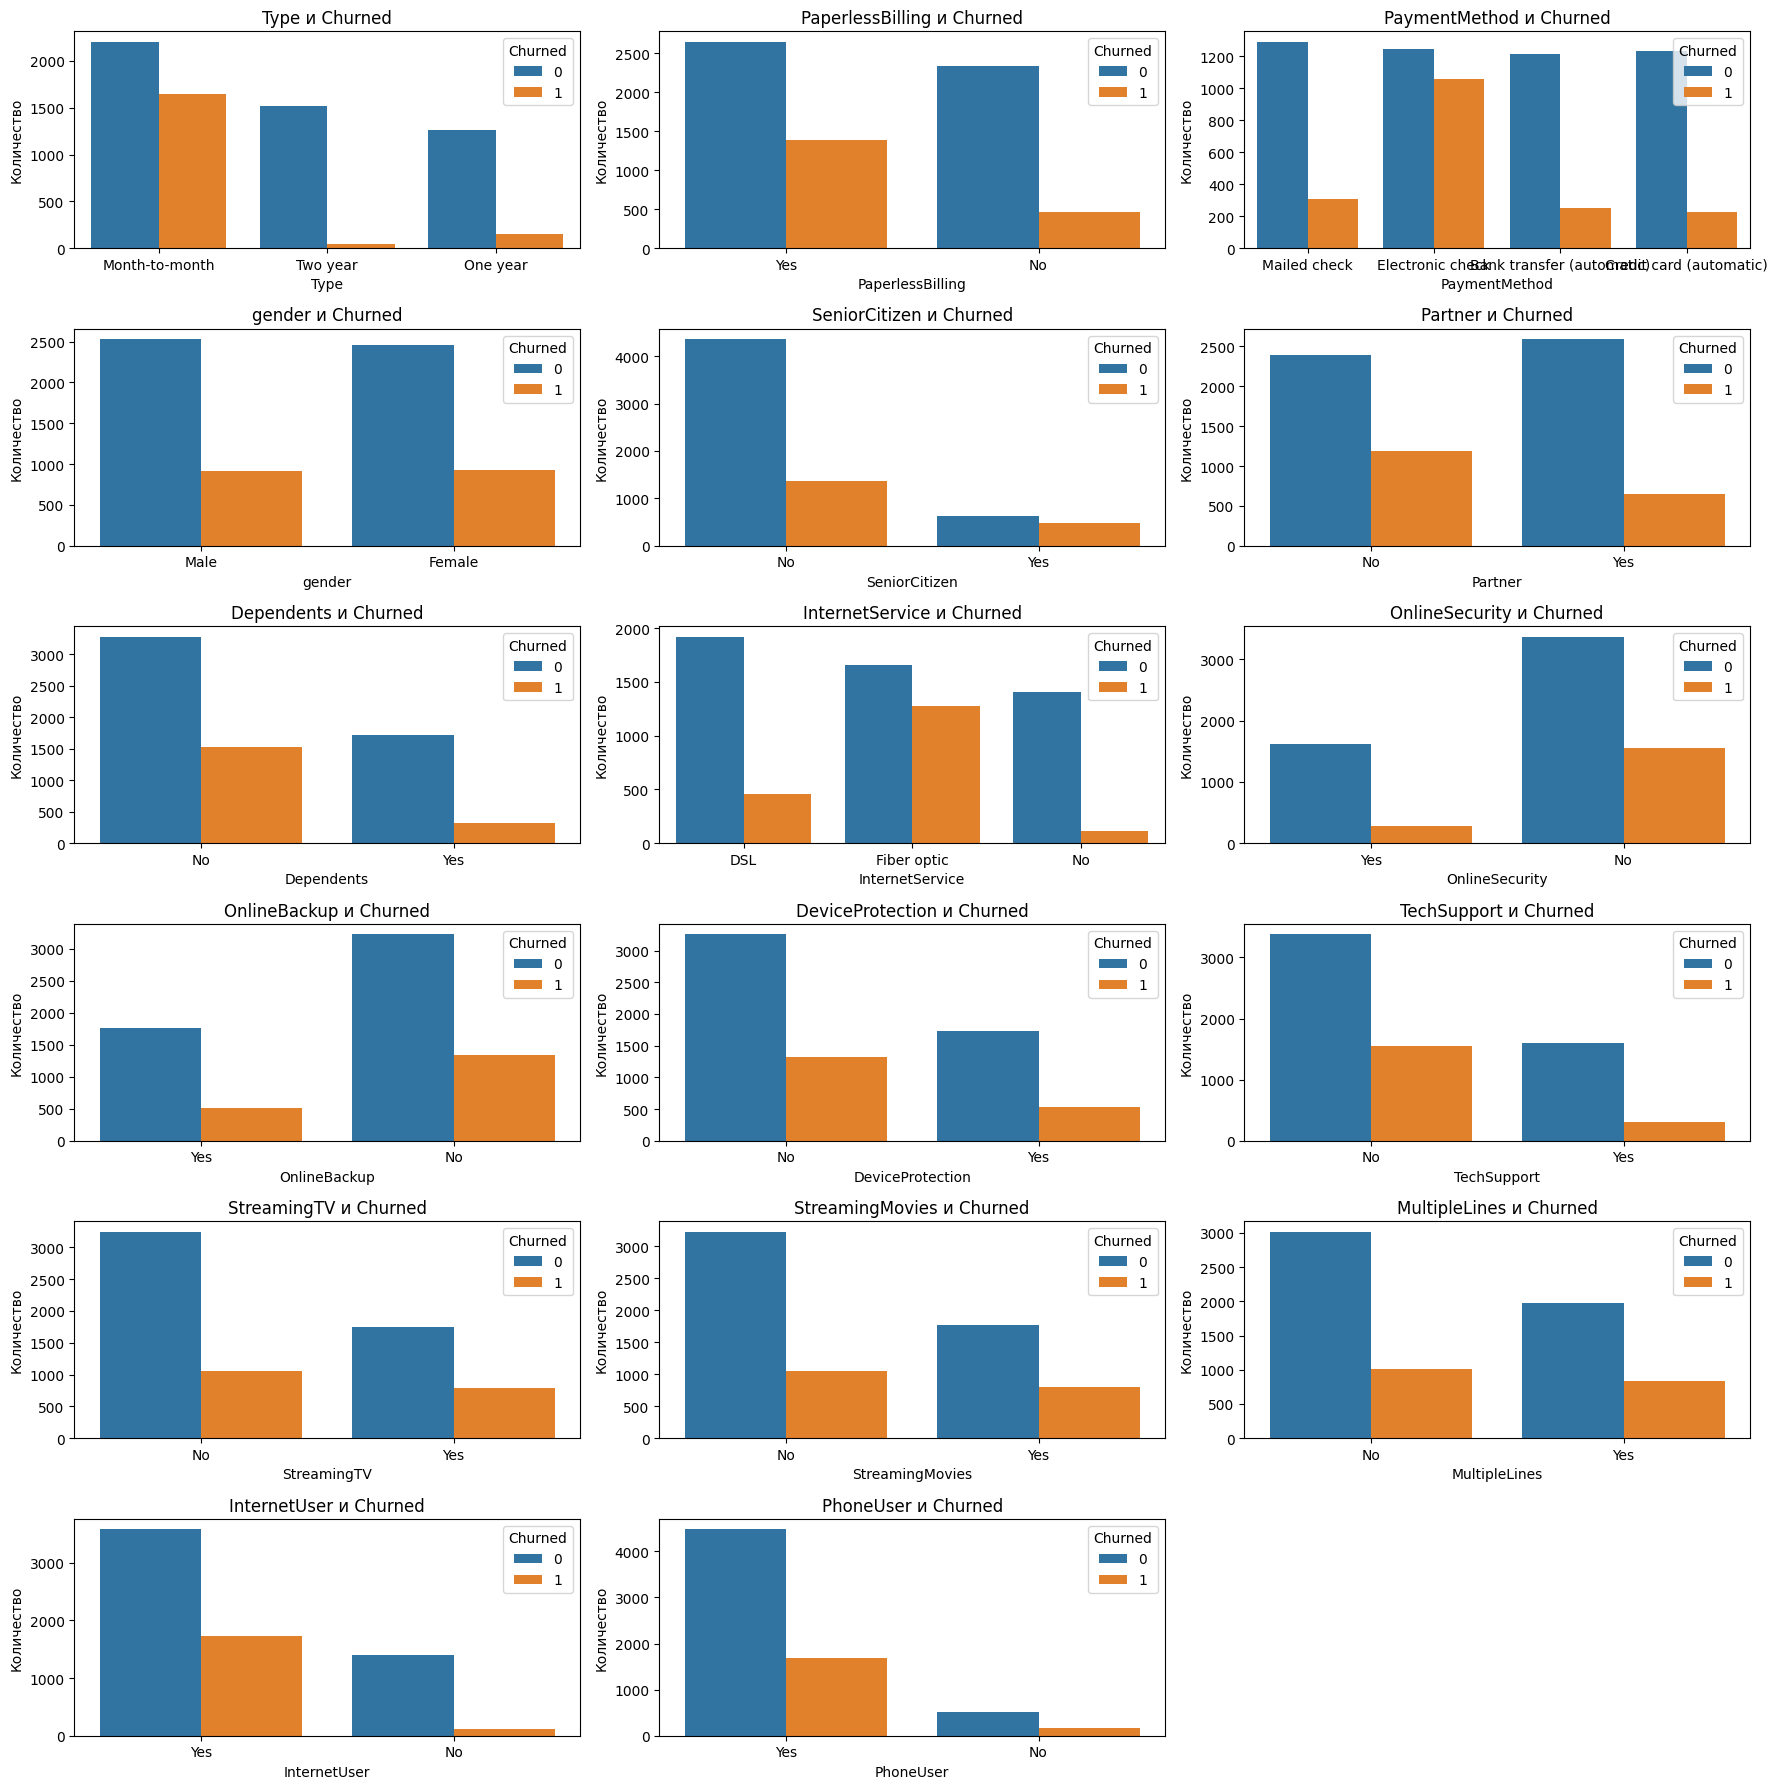

In [52]:
# Визуализируем информацию по числовым признакам
numerical_features = ['MonthlyCharges', 'TotalCharges', 'DailyCharges', 'ContractDuration']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=data, x=feature, hue='Churned', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'{feature} и Churned')
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# Визуализируем информацию по категориальным признакам
categorical_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines', 'InternetUser', 'PhoneUser'
]

rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 3))

if rows == 1:
    axes = axes.reshape(-1)

for i, feature in enumerate(categorical_features):
    ax = axes[i // 3, i % 3]
    sns.countplot(data=data, x=feature, hue='Churned', ax=ax)
    ax.set_title(f'{feature} и Churned')
    ax.set_ylabel('Количество')

if len(categorical_features) % 3 != 0:
    for j in range(len(categorical_features), rows * 3):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### Проводим корелляционный анализ данных. Для большого количества категорильных признаков и численных признаков с ненормальным распределением оптимально для корреляционного анализа подходит phik.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'DailyCharges', 'Churned']


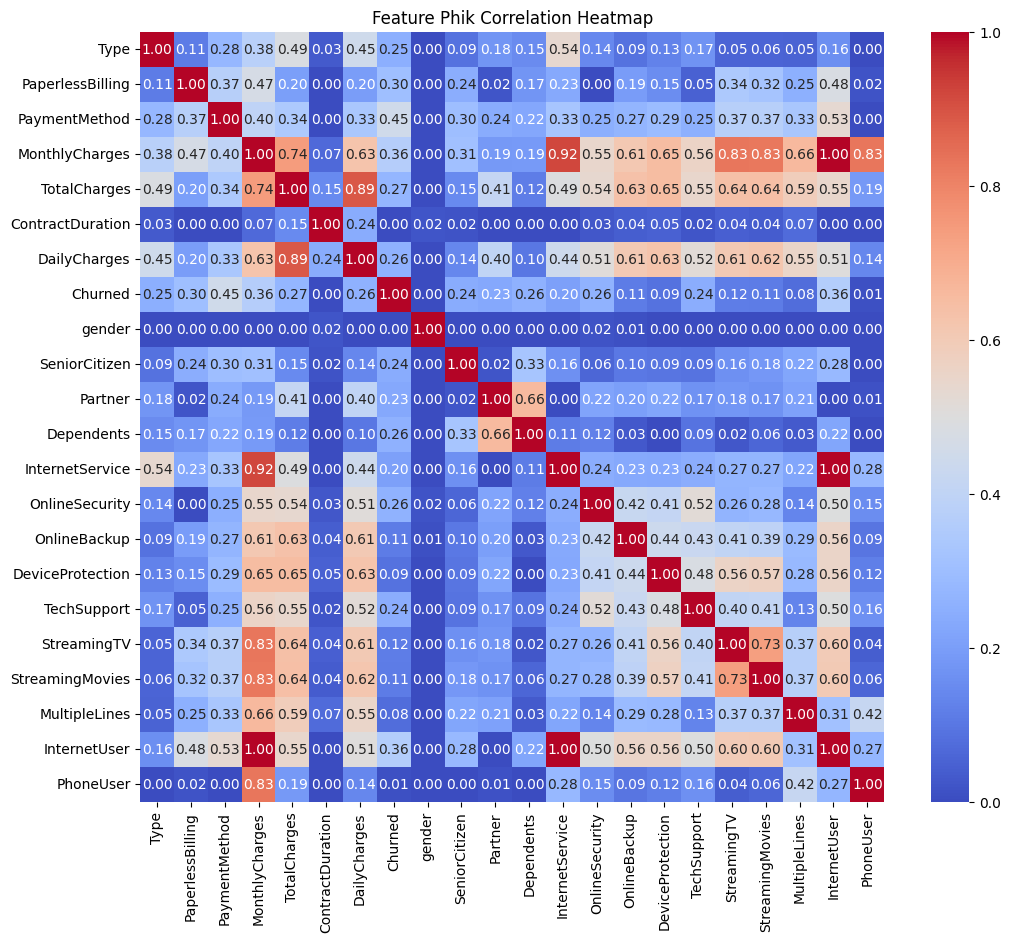

In [53]:
# Вычисляем корреляцию phik
correlation_matrix = data.phik_matrix()

# Визуализируем матрицу корреляции
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Phik Correlation Heatmap")
plt.show()

#### Выводы:

- Влияние признаков **ContractDuration, gender, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines и PhoneUser** на целевую переменную либо отсутствует вовсе, либо не существенно. Отказываемся от них на следующем этапе.
- Наибольшее влияние на целевую переменную оказывают признаки **Type, PaymentMethod, InternetService и MonthlyCharges.** Наблюдаются существенные различия в распределении целевого признака между значениями признаков **Type, PaymentMethod, InternetService**.

#### Удаляем лишние данные.

In [54]:
columns_to_drop = ['ContractDuration', 'gender', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies',
                   'MultipleLines', 'PhoneUser', 'SeniorCitizen', 'Partner']

data.drop(columns=columns_to_drop, inplace=True)

#### Выявляем и удаляем полные дубликаты.

In [55]:
# выводим количество дубликатов
print(data.duplicated().sum())

207


In [56]:
# удаляем дубликаты
data = data.drop_duplicates()

In [57]:
# выводим финальный результат
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 6833
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6627 non-null   string 
 1   PaperlessBilling  6627 non-null   string 
 2   PaymentMethod     6627 non-null   string 
 3   MonthlyCharges    6627 non-null   Int64  
 4   TotalCharges      6627 non-null   Int64  
 5   DailyCharges      6627 non-null   Float64
 6   Churned           6627 non-null   Int64  
 7   Dependents        6627 non-null   string 
 8   InternetService   6627 non-null   string 
 9   OnlineSecurity    6627 non-null   string 
 10  TechSupport       6627 non-null   string 
 11  InternetUser      6627 non-null   string 
dtypes: Float64(1), Int64(3), string(8)
memory usage: 698.9 KB


### Подготовка данных для обучения различных моделей.

#### Готовим тестовую и обучающую выборки.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Churned']),
    data.Churned,
    test_size=0.25,
    shuffle=True,
    random_state=SEED,
    stratify=data['Churned'])

categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Dependents', 'InternetService',
                        'OnlineSecurity', 'TechSupport', 'InternetUser']
numerical_features = ['MonthlyCharges', 'DailyCharges', 'TotalCharges']


#### Готовим данные для обучения модели случайного леса.






In [59]:
# Применяем ColumnTransformer
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
        ('num', "passthrough", numerical_features)
    ])

X_train_rf = rf_preprocessor.fit_transform(X_train)
X_test_rf = rf_preprocessor.transform(X_test)

### Готовим данные для обучения модели CatboostClassifier.

In [60]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

#### Готовим данные для подбора оптимальной архитектуры и обучения нейросети.

In [61]:
# Делим тренировочные данные на тренировочный и валидационный наборы
X_train_n, X_val, y_train_n, y_val = train_test_split(
    X_train, y_train, test_size=0.25, shuffle=True,
    random_state=SEED, stratify=y_train
)

# Определяем ColumnTransformer
preprocessor_nn = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Применяем преобразования
X_train_n = preprocessor_nn.fit_transform(X_train_n)
X_val = preprocessor_nn.transform(X_val)
X_test = preprocessor_nn.transform(X_test)

# Преобразуем данные в тензоры
X_train_n_t = torch.FloatTensor(X_train_n.astype('float32'))
X_val_t = torch.FloatTensor(X_val.astype('float32'))
X_test_t = torch.FloatTensor(X_test.astype('float32'))

y_train_n_t = torch.FloatTensor(y_train_n.values).squeeze().type(torch.FloatTensor)
y_val_t = torch.FloatTensor(y_val.values).squeeze().type(torch.FloatTensor)
y_test_t = torch.FloatTensor(y_test.values).squeeze().type(torch.FloatTensor)

## Обучаем различные модели.

### Подбираем оптимальные гиперпараметры и обучаем модель случайного леса.

In [62]:
%%time

# Применяем stratified_kfold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Создаем экземпляр классификатора
rfc_classifier = RandomForestClassifier(random_state=SEED, class_weight = 'balanced')

# Задаем сетку параметров для перебора
rfc_param_grid = {'n_estimators': list(range(10, 101, 10)),
                  'max_depth': list(range(1, 11))}

# Используем GridSearchCV для поиска оптимальных параметров
rfc_grid_search = GridSearchCV(rfc_classifier, param_grid=rfc_param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=1)

# Обучаем модель
rfc_grid_search.fit(X_train_rf, y_train)

# Выводим лучший результат и лучшие параметры
print("Лучшие найденные параметры модели RandomForestClassifier:", rfc_grid_search.best_params_)
print("Лучшее значение ROC_AUC:", rfc_grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие найденные параметры модели RandomForestClassifier: {'max_depth': 5, 'n_estimators': 100}
Лучшее значение ROC_AUC: 0.8308834776612761
CPU times: user 1min 44s, sys: 291 ms, total: 1min 44s
Wall time: 1min 45s


### Подбираем оптимальные гиперпараметры и обучаем модель CatboostСlassifier.

In [63]:
%%time

for col in X_train_cb.columns:
    if isinstance(X_train_cb[col].dtype, pd.core.arrays.floating.FloatingDtype):
        X_train_cb[col] = X_train_cb[col].astype('float')

# Создаем экземпляр классификатора
cbc_classifier = CatBoostClassifier(random_state=SEED, verbose=False, auto_class_weights='Balanced',
                                    cat_features=categorical_features)

# Задаем сетку параметров для перебора
cbc_param_grid = {
    'learning_rate': [0.01, 0.03],
    'iterations': [1000],
    'depth': [5, 6]
}

# Используем GridSearchCV для поиска оптимальных параметров
cbc_grid_search = GridSearchCV(estimator=cbc_classifier, param_grid=cbc_param_grid, cv=stratified_kfold, scoring='roc_auc')

# Обучаем модель
cbc_grid_search.fit(X_train_cb, y_train)


# Выводим лучший результат и лучшие параметры
print('Лучшее значение ROC_AUC:', cbc_grid_search.best_score_)
print('Лучшие параметры:', cbc_grid_search.best_params_)

Лучшее значение ROC_AUC: 0.8349750262879319
Лучшие параметры: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.01}
CPU times: user 3min 38s, sys: 20.4 s, total: 3min 58s
Wall time: 2min 30s


### Строим модель нейросети.

#### Создаем функцию обучения и определения модели нейронной сети.

In [74]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class BinaryClassifier(nn.Module):
    def __init__(self, layer_structure):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(15, layer_structure[0]))
        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))
        self.layers.append(nn.Linear(layer_structure[-1], 1))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            if i % 2 == 0:
                x = torch.tanh(self.layers[i](x))
            else:
                x = torch.sigmoid(self.layers[i](x))
        x = torch.sigmoid(self.layers[-1](x))
        return x.squeeze()

# Обучение модели
def train_model(model, X_train_n_t, y_train_n_t, X_val_t, y_val_t, learning_rate=0.003, early_stopping_patience=500,
                weight_decay=1e-3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_roc_auc = float('-inf')
    best_train_roc_auc = float('-inf')
    no_improve_epochs = 0
    epochs = 0

    train_roc_aucs = []
    val_roc_aucs = []

    while True:
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train_n_t)
        loss = criterion(train_outputs, y_train_n_t)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            train_roc_auc = roc_auc_score(y_train_n_t.numpy(), train_outputs.numpy())
            val_outputs = model(X_val_t)
            val_roc_auc = roc_auc_score(y_val_t.numpy(), val_outputs.numpy())

            train_roc_aucs.append(train_roc_auc)
            val_roc_aucs.append(val_roc_auc)

            if val_roc_auc > best_roc_auc:
                best_roc_auc = val_roc_auc
                best_train_roc_auc = train_roc_auc
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if epochs % 200 == 0:
            print(f"Epoch {epochs} - ROC_AUC при обучении: {train_roc_auc}, ROC_AUC при валидации: {val_roc_auc}")

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break

        epochs += 1

    return model, best_roc_auc, best_train_roc_auc, train_roc_aucs, val_roc_aucs

#### Подбираем наилучшую архитектуру нейросети по количеству скрытых слоев и нейронов в них с выводом метрики.

In [75]:
%%time

neurons_per_layer = [32, 16]
max_hidden_layers = 3

best_overall_roc_auc = float('-inf')
best_overall_model_structure = None
best_overall_train_roc_auc = float('-inf')
best_overall_train_roc_aucs = []
best_overall_val_roc_aucs = []

# best_model_path = "/content/best_model.pth"

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in tqdm(layer_structures, desc="Обучение моделей", unit="модель"):
    model = BinaryClassifier(layer_structure)
    model.apply(init_weights)
    model, best_roc_auc, best_train_roc_auc, train_roc_aucs, val_roc_aucs = train_model(model, X_train_n_t,
                                                                                        y_train_n_t, X_val_t, y_val_t)

    if best_roc_auc > best_overall_roc_auc:
        best_overall_roc_auc = best_roc_auc
        best_overall_model_structure = layer_structure
        best_overall_train_roc_auc = best_train_roc_auc
        best_overall_train_roc_aucs = train_roc_aucs
        best_overall_val_roc_aucs = val_roc_aucs
#         torch.save(model.state_dict(), best_model_path)

# Выводим только наилучшую метрику на этапе валидации
print(f"Лучшая архитектура: {best_overall_model_structure}")
print(f"Лучшее значение ROC_AUC на этапе валидации: {best_overall_roc_auc}")


Обучение моделей:   0%|          | 0/8 [00:00<?, ?модель/s]

Epoch 0 - ROC_AUC при обучении: 0.6927785396340093, ROC_AUC при валидации: 0.6875510011397279
Epoch 200 - ROC_AUC при обучении: 0.8382885211995865, ROC_AUC при валидации: 0.8248848470134407
Epoch 400 - ROC_AUC при обучении: 0.8427817244428458, ROC_AUC при валидации: 0.8284422818837207
Epoch 600 - ROC_AUC при обучении: 0.8471095049683017, ROC_AUC при валидации: 0.8303339605209028
Epoch 800 - ROC_AUC при обучении: 0.849432354660312, ROC_AUC при валидации: 0.8295415461185183
Epoch 1000 - ROC_AUC при обучении: 0.8512402020292853, ROC_AUC при валидации: 0.827713935028763


Обучение моделей:  12%|█▎        | 1/8 [00:11<01:19, 11.40s/модель]

Early stopping at epoch 1079
Epoch 0 - ROC_AUC при обучении: 0.3189428682763065, ROC_AUC при валидации: 0.3556102939688834
Epoch 200 - ROC_AUC при обучении: 0.8387265260854577, ROC_AUC при валидации: 0.8253198319407071
Epoch 400 - ROC_AUC при обучении: 0.8449545134361465, ROC_AUC при валидации: 0.8292448122146465
Epoch 600 - ROC_AUC при обучении: 0.8501506227237984, ROC_AUC при валидации: 0.8272620902205947
Epoch 800 - ROC_AUC при обучении: 0.8529721760112704, ROC_AUC при валидации: 0.8239879013494649


Обучение моделей:  25%|██▌       | 2/8 [00:21<01:02, 10.40s/модель]

Early stopping at epoch 957
Epoch 0 - ROC_AUC при обучении: 0.6164677097852315, ROC_AUC при валидации: 0.6406282666019247
Epoch 200 - ROC_AUC при обучении: 0.8389355994184913, ROC_AUC при валидации: 0.8251883248696732
Epoch 400 - ROC_AUC при обучении: 0.8444857845120871, ROC_AUC при валидации: 0.828725527882871
Epoch 600 - ROC_AUC при обучении: 0.8492345218290545, ROC_AUC при валидации: 0.8300507145217525
Epoch 800 - ROC_AUC при обучении: 0.8515815385998832, ROC_AUC при валидации: 0.829362831380959
Epoch 1000 - ROC_AUC при обучении: 0.8521150877508507, ROC_AUC при валидации: 0.8286277405736405


Обучение моделей:  38%|███▊      | 3/8 [00:32<00:54, 10.82s/модель]

Early stopping at epoch 1141
Epoch 0 - ROC_AUC при обучении: 0.5918525096293632, ROC_AUC при валидации: 0.6376288937894942
Epoch 200 - ROC_AUC при обучении: 0.8370721115657269, ROC_AUC при валидации: 0.8248106635374728
Epoch 400 - ROC_AUC при обучении: 0.8420469703100879, ROC_AUC при валидации: 0.8286580883592638
Epoch 600 - ROC_AUC при обучении: 0.8462226293781754, ROC_AUC при валидации: 0.8293527154524181
Epoch 800 - ROC_AUC при обучении: 0.8498407595581735, ROC_AUC при валидации: 0.8256367977016609
Epoch 1000 - ROC_AUC при обучении: 0.8532024189559821, ROC_AUC при валидации: 0.8216140301184913


Обучение моделей:  50%|█████     | 4/8 [00:41<00:40, 10.08s/модель]

Early stopping at epoch 1022
Epoch 0 - ROC_AUC при обучении: 0.2044029045456589, ROC_AUC при валидации: 0.2114262784847688
Epoch 200 - ROC_AUC при обучении: 0.8418169147070725, ROC_AUC при валидации: 0.8273194138156607
Epoch 400 - ROC_AUC при обучении: 0.8458462599103758, ROC_AUC при валидации: 0.8306441823294961
Epoch 600 - ROC_AUC при обучении: 0.8483330335866192, ROC_AUC при валидации: 0.8304587236395762
Epoch 800 - ROC_AUC при обучении: 0.8500011240501777, ROC_AUC при валидации: 0.8293291116191555


Обучение моделей:  62%|██████▎   | 5/8 [00:50<00:28,  9.67s/модель]

Early stopping at epoch 930
Epoch 0 - ROC_AUC при обучении: 0.5150426015017311, ROC_AUC при валидации: 0.5231806502518865
Epoch 200 - ROC_AUC при обучении: 0.8374162582617687, ROC_AUC при валидации: 0.8234652450415091
Epoch 400 - ROC_AUC при обучении: 0.8434033241910586, ROC_AUC при валидации: 0.8261324782001741
Epoch 600 - ROC_AUC при обучении: 0.850568394706473, ROC_AUC при валидации: 0.8264730477943905
Epoch 800 - ROC_AUC при обучении: 0.8555988939346253, ROC_AUC при валидации: 0.8245240455621421


Обучение моделей:  75%|███████▌  | 6/8 [00:59<00:19,  9.66s/модель]

Epoch 1000 - ROC_AUC при обучении: 0.8570684022001409, ROC_AUC при валидации: 0.8230268881380621
Early stopping at epoch 1009
Epoch 0 - ROC_AUC при обучении: 0.3540085502750176, ROC_AUC при валидации: 0.3700794437588093
Epoch 200 - ROC_AUC при обучении: 0.8387025463483357, ROC_AUC при валидации: 0.8242003358488275
Epoch 400 - ROC_AUC при обучении: 0.843565187416633, ROC_AUC при валидации: 0.8278285822188952
Epoch 600 - ROC_AUC при обучении: 0.848595686644785, ROC_AUC при валидации: 0.8268203613409674
Epoch 800 - ROC_AUC при обучении: 0.8522481003551998, ROC_AUC при валидации: 0.8242947511818777


Обучение моделей:  88%|████████▊ | 7/8 [01:07<00:09,  9.12s/модель]

Early stopping at epoch 970
Epoch 0 - ROC_AUC при обучении: 0.6864008662680036, ROC_AUC при валидации: 0.6688264174101873
Epoch 200 - ROC_AUC при обучении: 0.8343000164860693, ROC_AUC при валидации: 0.8225042318301063
Epoch 400 - ROC_AUC при обучении: 0.8407689252581568, ROC_AUC при валидации: 0.8265742070798012
Epoch 600 - ROC_AUC при обучении: 0.8433047824588222, ROC_AUC при валидации: 0.8285872768594762
Epoch 800 - ROC_AUC при обучении: 0.8467458747358482, ROC_AUC при валидации: 0.8291301650245143
Epoch 1000 - ROC_AUC при обучении: 0.8505826326753891, ROC_AUC при валидации: 0.8263280528186348
Epoch 1200 - ROC_AUC при обучении: 0.8528146216447102, ROC_AUC при валидации: 0.8238260464928077


Обучение моделей: 100%|██████████| 8/8 [01:19<00:00,  9.88s/модель]

Early stopping at epoch 1275
Лучшая архитектура: (16, 32, 32)
Лучшее значение ROC_AUC на этапе валидации: 0.8309173124001051
CPU times: user 1min 17s, sys: 276 ms, total: 1min 17s
Wall time: 1min 19s


### Выводы по итогам обучения моделей.

- Все модели показали приличный результат по метрике ROC_AUC.
- Модель CatBoost показала наилучший результат.

## Тестирование лучшей модели и демонстрация ее работы.

### Проверяем качество модели на тестовой выборке.

In [66]:
# Используем лучшую модель из GridSearch
best_model = cbc_grid_search.best_estimator_

# Предсказываем вероятности для тестового набора
y_test_pred_proba = best_model.predict_proba(X_test_cb)[:, 1]

# Рассчитываем ROC AUC
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba)
print(f'ROC AUC на тестовой выборке: {roc_auc_score_test}')

ROC AUC на тестовой выборке: 0.8638009135535718


### Строим матрицу ошибок. Рассчитываем и выводим на экран значения полноты и точности.

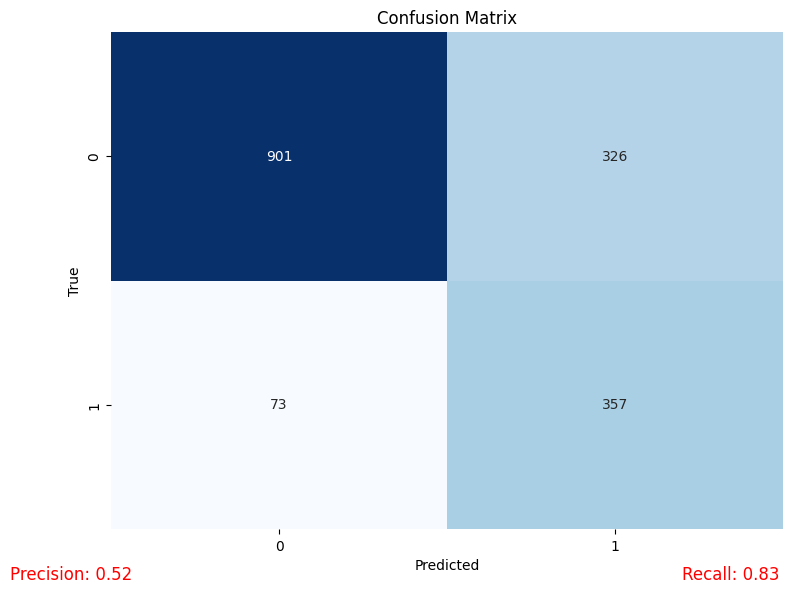

In [76]:
# Истинные и предсказанные значения
y_true = y_test_t.numpy()
y_pred = best_model.predict(X_test_cb)

# Построение матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred)

# Вычисление precision и recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Добавление текста для precision и recall
plt.text(-0.3, 2.2, f'Precision: {precision:.2f}', fontsize=12, color='red')
plt.text(1.7, 2.2, f'Recall: {recall:.2f}', fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Анализируем важность признаков, влияющих на отток клиентов.

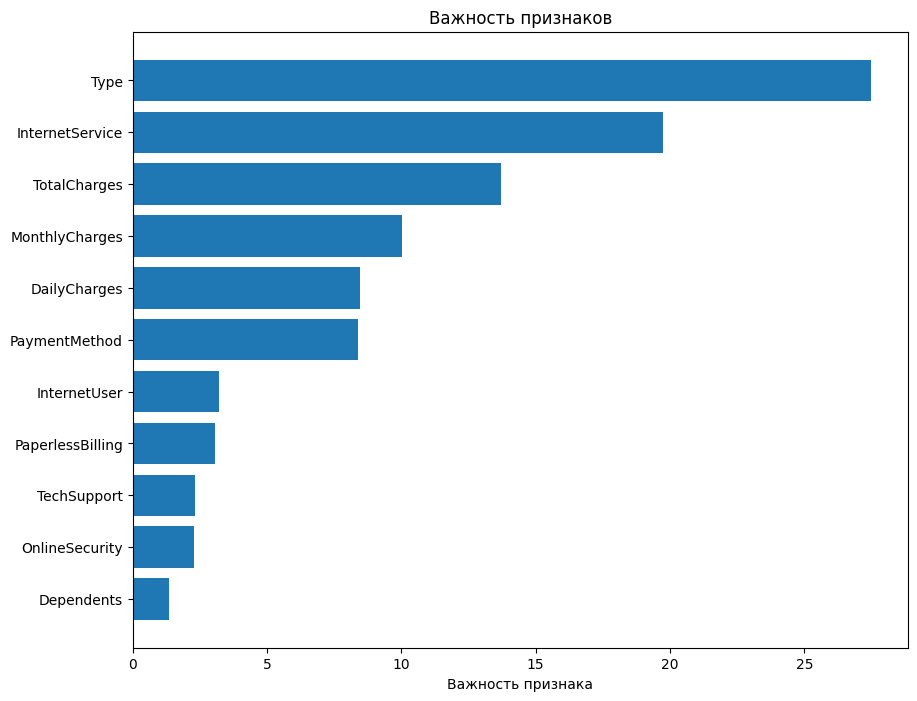

In [77]:
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns
# Сортируем признаки по важности
sorted_indices = np.argsort(feature_importances)

# Рисуем гистограмму
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Важность признака')
plt.title('Важность признаков')
plt.show()

Наиболее важными признаками для вычисления оттока клиентов являются:
- Тип оплаты
- Способ оплаты
- Общие расходы
- Ежемесячные расходы

### Анализируем зависимость наиболее важных признаков и целевой переменной.

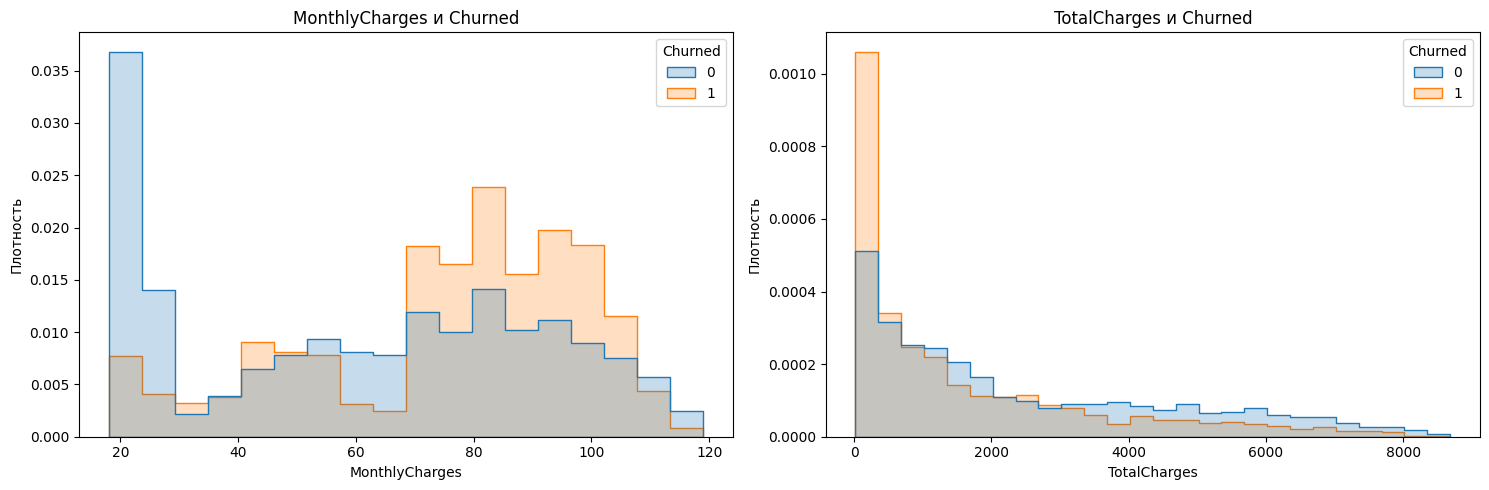

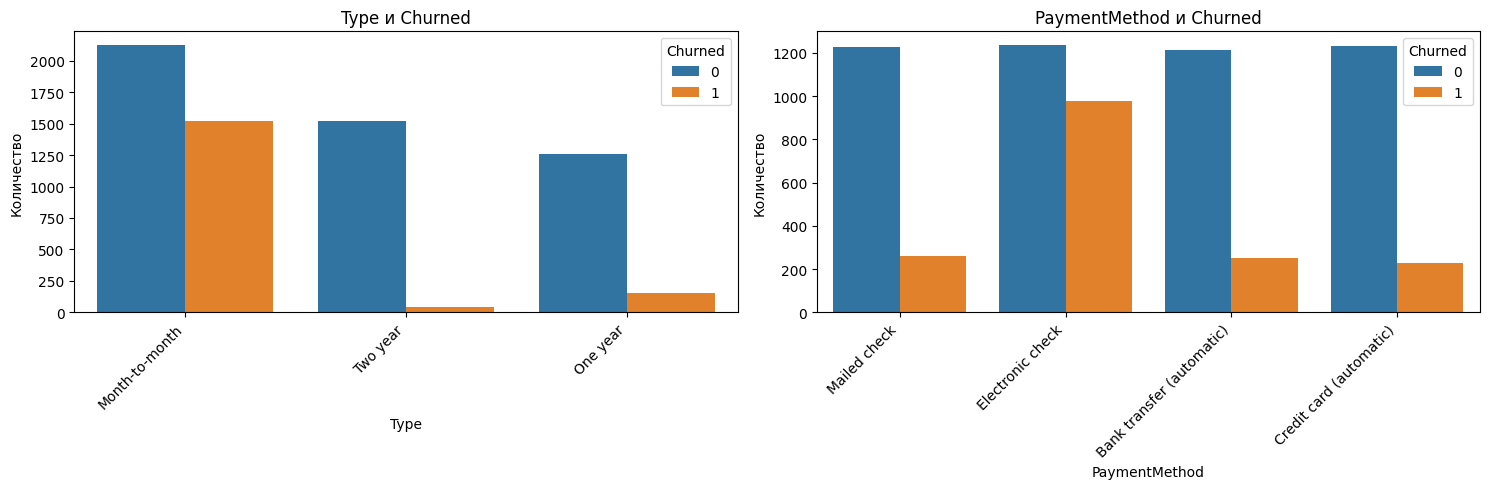

In [80]:
# Только числовые признаки
numerical_features = ['MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=data, x=feature, hue='Churned', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'{feature} и Churned')
    ax.set_ylabel('Плотность')

plt.tight_layout()
plt.show()

# Теперь все категориальные признаки
categorical_features = ['Type', 'PaymentMethod']

rows = math.ceil(len(categorical_features) / 2)
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 5))

# Убедимся, что axes всегда двумерный
axes = np.array(axes).reshape(rows, -1)

for i, feature in enumerate(categorical_features):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=data, x=feature, hue='Churned', ax=ax)
    ax.set_title(f'{feature} и Churned')
    ax.set_ylabel('Количество')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Выводы:
- **Общие расходы:** Клиенты, которые понесли существенные общие расходы (более 400 уе) гораздо реже меняют провайдера.
- **Ежемесячные расходы:** Клиенты, у которых ежемесячные расходы превышают 70 уе гораздо чаще меняют провайдера.
- **Тип оплаты:** Оплата услуг на на год или два года вперед существенно снижает риск ухода клиентов.
- **Порядок оплаты:** Клиенты, у которых деньги списываются автоматически - гораздо реже уходят от провайдера.

## Обший вывод по работе.

Бизнес-рекомендации для заказчика:
- Предложить клиентам, планирующим сменить провайдера, специальные условия с оплатой на год или два года вперед. При этом в расчете на месяц расходы клиента не должны превышать 70 уе.
- Постепенно переводить всех клиентов на автоматическое списание платежей за услуги.